### Importing packages

In [1]:
import os
import re
import math
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from scipy import stats
import networkx as nx
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations, chain
import vectorbt as vbt
import textwrap
from rapidfuzz.fuzz import ratio
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

### Helper Functions

In [2]:
%run "../utils/functions.py"

### Load data

In [3]:
with open(
    file="../data/coin_px_vol_2022-06-24_to_2025-06-24.pkl", 
    mode="rb"
    ) as f:
    data_dict = pickle.load(f)

coin_prices = pd.concat(
    [
        data_dict[i]["price"] for i in data_dict
    ],
    axis=1
)

coin_prices.columns = [i for i in data_dict]

coin_prices = coin_prices.dropna(
    axis = 1,
    thresh = 0.99 * coin_prices.shape[0]
).ffill(limit=2).replace(np.nan, 0)

coin_prices.tail(4)

,SOL,BTC,XRP,DOGE,ETH,ADA,BNB,TRX,AAVE,UNI,...,BICO,FIST,GMX,BAND,LRC,RARE,SKL,TWT,HNT,PHB
date,,,,,,,,,,,,,,,,,,,,,
2025-06-21,140.061295,103290.105145,2.120113,0.162332,2403.607721,0.576848,641.466075,0.272483,247.264404,7.073481,...,0.089715,0.321726,14.070058,0.584629,0.075146,0.048383,0.017951,0.722245,2.428924,0.414596
2025-06-22,133.866437,101532.568385,2.044380,0.153080,2277.899190,0.550708,626.568767,0.270289,231.713187,6.388992,...,0.085296,0.437483,13.186598,0.550390,0.071409,0.044991,0.016872,0.684994,2.251220,0.385577
2025-06-23,132.210728,100852.582646,2.013513,0.151148,2229.907577,0.541130,615.920084,0.263612,227.555713,6.260848,...,0.082184,0.434130,12.899459,0.520715,0.069055,0.043732,0.016632,0.669218,2.171437,0.374358
2025-06-24,144.786261,105511.624379,2.164008,0.164473,2422.994920,0.583240,640.254318,0.273023,258.018653,6.830906,...,0.093872,0.448770,14.122592,0.588557,0.077711,0.048367,0.018450,0.712156,2.355143,0.425652


### Rolling Validation Splits for Pairs Trading Strategy

In [4]:
n_splits = 20

# Generate and capture the figure
fig = coin_prices.vbt.rolling_split(
    n=n_splits,
    window_len=455,
    set_lens=(90,),
    left_to_right=False,
    plot=True
)

# Clean it up with just a few tweaks
fig.update_layout(
    title="Fig 1. Rolling Validation Splits for Pairs Trading Strategy (365 Days Train / 90 Days Test)",
    font=dict(size=12),
    xaxis_title="Date",
    yaxis_title="Split Index",
    height=400,
    width=800,
    margin=dict(l=30, r=30, t=60, b=30)  # Padding inside border
)

FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': '0',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': '608caffa-7adf-487c-9d31-d04edbb2cfa1',
              'x': array([datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 26, 0, 0),
                          datetime.datetime(2022, 6, 27, 0, 0), ...,
                          datetime.datetime(2025, 6, 22, 0, 0),
                          datetime.datetime(2025, 6, 23, 0, 0),
                          datetime.datetime(2025, 6, 24, 0, 0)], shape=(1097,), dtype=object),
              'y': array([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
                           1,  0]),
              'z': array([[nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
              

In [5]:
n_splits = 20

splits = coin_prices.vbt.rolling_split(
    n=n_splits,
    window_len=455,
    set_lens=(365,)
)

(in_price, in_indexes), (out_price, out_indexes) = splits

In [6]:
performance_stats = []
plots = []

for indic in range(n_splits):
    train = in_price[indic].set_index(in_indexes[indic])
    test = out_price[indic].set_index(out_indexes[indic])

    scaler = StandardScaler()

    train_norm = pd.DataFrame(
        data=scaler.fit_transform(train), 
        columns=train.columns, 
        index=train.index
    )

    test_norm = pd.DataFrame(
        data=scaler.fit_transform(test), 
        columns=test.columns, 
        index=test.index
    )

    final_pairs = get_cointegrated_pairs(prices=train_norm)

    print(f"Selected {len(final_pairs)} Pairs for Backtesting Period {indic+1}:", textwrap.fill("  ".join([f"({a}, {b})" for a, b in final_pairs]), width=200))
    print("\n"+"----------------"*10)

    rolling_params = get_rolling_signals(
        prices=coin_prices, 
        select_pairs=final_pairs
    )

    all_positions = get_long_short_signals(
        prices=test_norm, 
        select_pairs=final_pairs, 
        rolling_params=rolling_params, 
        threshold=0.5
    )

    out_sample_returns = coin_prices.pct_change().loc[
        test_norm.index[0]:test_norm.index[-1]
    ][all_positions.columns]

    baseline_strategy_btc_hold = test["BTC"].pct_change().rename("BTC Buy & Hold")
    net_returns = (all_positions.shift() * out_sample_returns).sum(axis=1).rename("Equal Weighted Portfolio")
    max_sharpe_weighted_port_returns = optimal_portfolio_weights(returns=out_sample_returns, objective="max_sharpe")
    min_volatility_weighted_port_returns = optimal_portfolio_weights(returns=out_sample_returns, objective="min_volatility")
    max_quad_weighted_port_returns = optimal_portfolio_weights(returns=out_sample_returns, objective="max_quad")

    all_strat_net_daily_returns = pd.concat(
        [
            baseline_strategy_btc_hold,
            net_returns, 
            max_sharpe_weighted_port_returns, 
            min_volatility_weighted_port_returns, 
            max_quad_weighted_port_returns
        ], 
        axis=1
    )

    plots.append((1 + all_strat_net_daily_returns).cumprod())

    performance_stats.append(all_strat_net_daily_returns.drop(columns="BTC Buy & Hold").apply(
        lambda strat_returns: compute_performance_metrics(
            strategy_returns=strat_returns, 
            benchmark_returns=all_strat_net_daily_returns["BTC Buy & Hold"]
        ),
        axis=0
    ).T
    )

Selected 20 Pairs for Backtesting Period 1: (BORA, AXS)  (ENJ, BICO)  (ZEC, BSV)  (ZEN, BSW)  (BTCB, BTC.B)  (IOTA, CRO)  (MANA, ENJ)  (STMX, IOTA)  (CRO, KAVA)  (CELO, KSM)  (ORBS, MANA)  (BSW, PRO)  (YGG, RARE)  (OM, STMX)  (ZIL, STORJ)
(DOT, THETA)  (GMT, WAVES)  (1INCH, WIN)  (FLOW, ZEN)  (BAT, ZIL)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected 22 Pairs for Backtesting Period 2: (BORA, BAT)  (THETA, BICO)  (AIOZ, BSW)  (IOTA, CRO)  (MANA, ENJ)  (SAND, GMT)  (CRO, HNT)  (GMT, IOTA)  (CELO, KSM)  (WAVAX, MANA)  (STORJ, RARE)  (OM, SAND)  (BTC.B, STETH)  (XTZ, STORJ)  (DOT,
THETA)  (JST, VET)  (RAY, WAVES)  (BAT, WIN)  (FLOW, XTZ)  (AXS, YGG)  (BTT, ZEC)  (ZEC, ZEN)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected 18 Pairs for Backtesting Per

In [7]:
performance_stats[0]

,Holding Period (Days),Holding Period (Months),Holding Period (Years),Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Win Rate,Avg Win,Avg Loss,Profit Factor,Alpha,Beta,R-squared
Equal Weighted Portfolio,90.0,4.29,0.36,-0.971773,-0.999954,3.122980,-1.104560,-1.281095,-0.984978,0.500000,0.127875,-0.158781,0.823660,-3.130201,1.148133,0.008784
Weighted Portfolio for Max Sharpe,90.0,4.29,0.36,0.933682,5.336923,0.922477,2.450048,4.512464,-0.307106,0.500000,0.049307,-0.031369,1.571815,2.545412,1.267203,0.123261
Weighted Portfolio for Min Volatility,90.0,4.29,0.36,-0.092811,-0.238704,0.209483,-1.196886,-1.474880,-0.175702,0.500000,0.008455,-0.010445,0.809486,-0.112263,0.666344,0.684352
Weighted Portfolio for Max Quadratic Utility,90.0,4.29,0.36,0.811222,4.276192,1.430208,1.822355,3.309717,-0.483986,0.488889,0.066401,-0.043279,1.467567,2.920346,1.342694,0.057389


# PLOTS & FIGURES

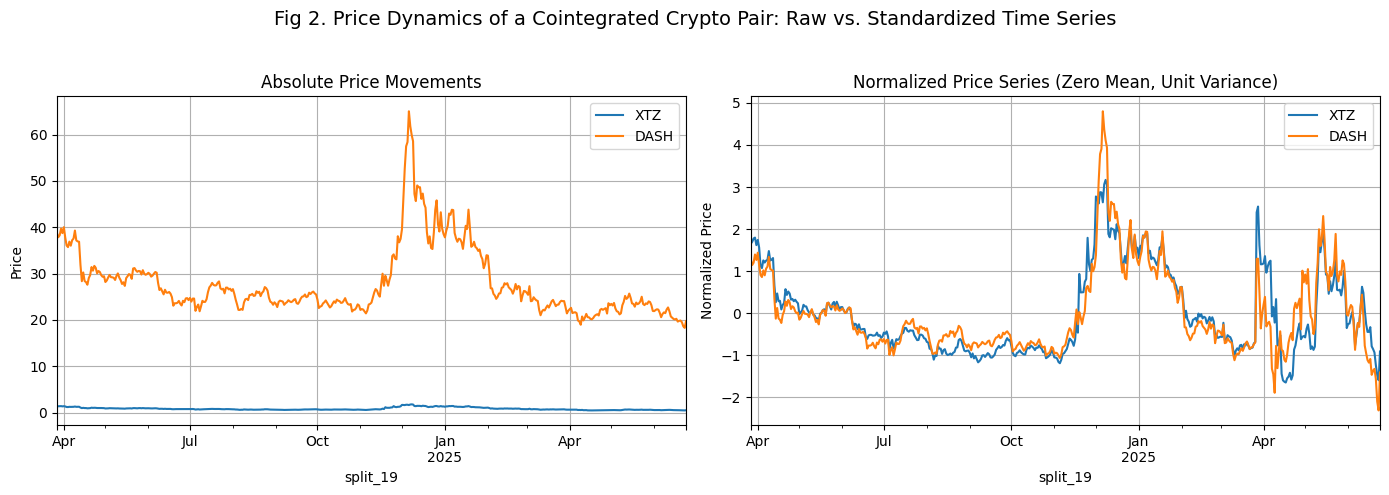

In [10]:
comparison_absolute_vs_norm_prices(
    pairs_list=final_pairs[8], 
    train=pd.concat([train, test], axis=0), 
    train_norm=pd.concat([train_norm, test_norm], axis=0)
)

In [21]:
zscore_series.min(), zscore_series.max()

(np.float64(-2.3156032300689753), np.float64(-0.19491798504668242))

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>)

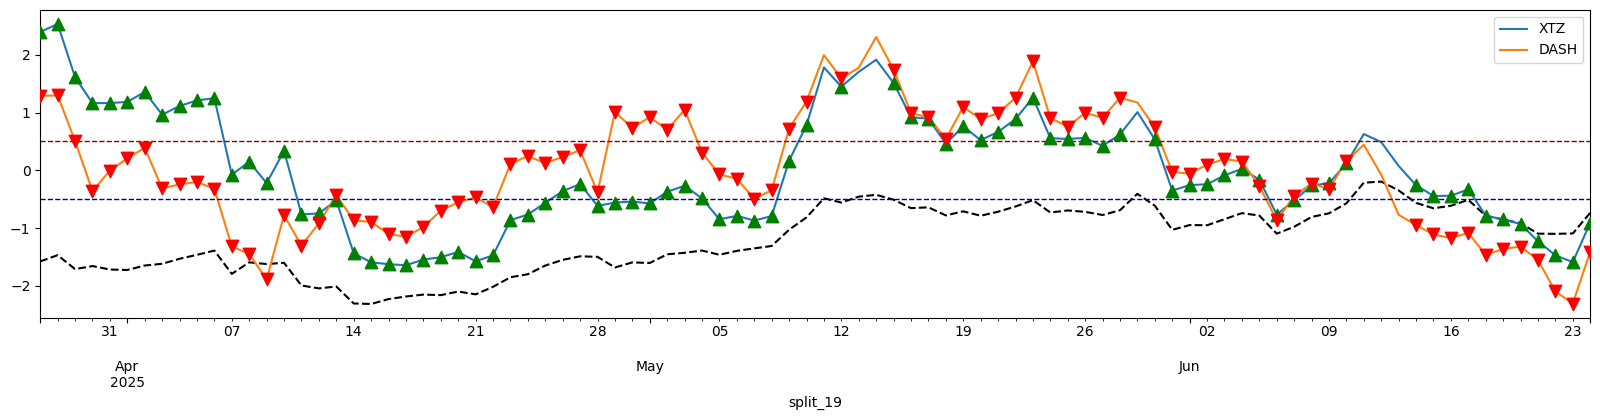

In [12]:
pair = tuple(final_pairs[8])
coin1, coin2 = pair
threshold = 0.5

# Get z-score and coin prices
zscore_series = rolling_params[pair]["rolling_z_score"].loc[test_norm.index]
coin1_series = test_norm[coin1]
coin2_series = test_norm[coin2]

# Define signals
buy_signals = zscore_series[zscore_series < -threshold]   # Buy coin1, short coin2
short_signals = zscore_series[zscore_series > threshold]  # Short coin1, buy coin2

# Plot base
ax = zscore_series.rename("Z-Score").plot(figsize=(20, 4), color="black", linestyle="--")
test_norm[[coin1, coin2]].plot(ax=ax)

# Threshold lines
ax.axhline(threshold, color="darkred", linestyle="--", linewidth=1, label=f"Upper Threshold (+{threshold})")
ax.axhline(-threshold, color="navy", linestyle="--", linewidth=1, label=f"Lower Threshold (-{threshold})")

# BUY SIGNAL (z < -threshold): Buy coin1, Short coin2
ax.scatter(buy_signals.index, coin1_series.loc[buy_signals.index], color='green', marker='^', s=80, label=f"Buy {coin1}", zorder=5)
ax.scatter(buy_signals.index, coin2_series.loc[buy_signals.index], color='red', marker='v', s=80, label=f"Short {coin2}", zorder=5)

# SHORT SIGNAL (z > threshold): Short coin1, Buy coin2
ax.scatter(short_signals.index, coin1_series.loc[short_signals.index], color='darkred', marker='v', s=80, label=f"Short {coin1}", zorder=5)
ax.scatter(short_signals.index, coin2_series.loc[short_signals.index], color='darkgreen', marker='^', s=80, label=f"Buy {coin2}", zorder=5)

# Format plot
ax.set_title(f"Fig 3. Trading Signals on Price for Pair: {coin1} / {coin2}")
ax.set_ylabel("Normalized Price / Z-Score")
ax.set_xlabel("Date")
ax.legend(loc="center left", bbox_to_anchor=(1.005, 0.5))
plt.tight_layout()
plt.show()

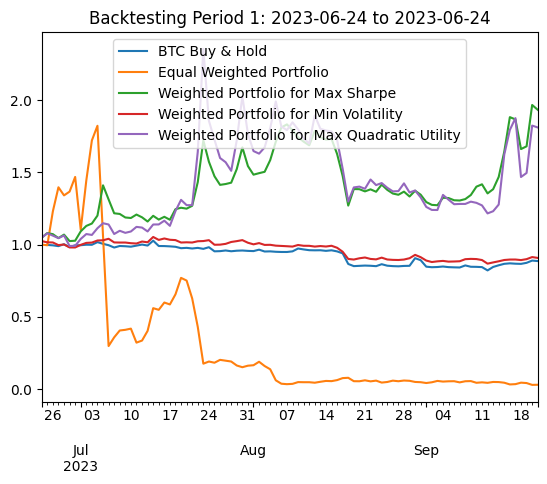

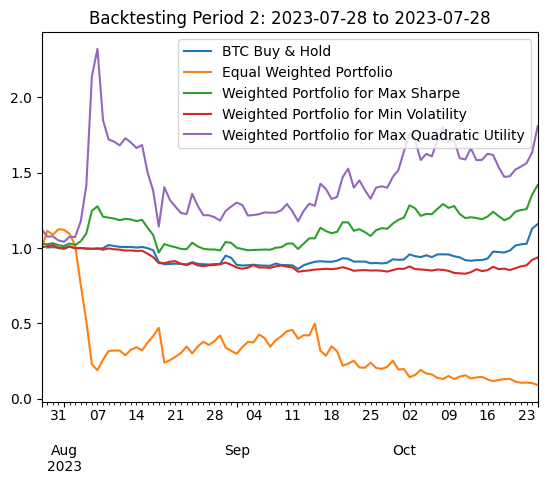

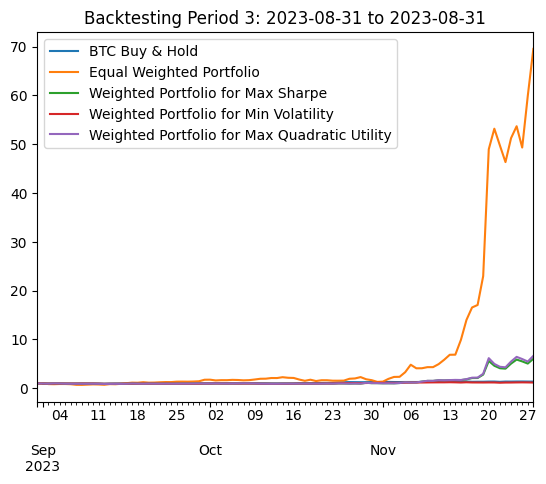

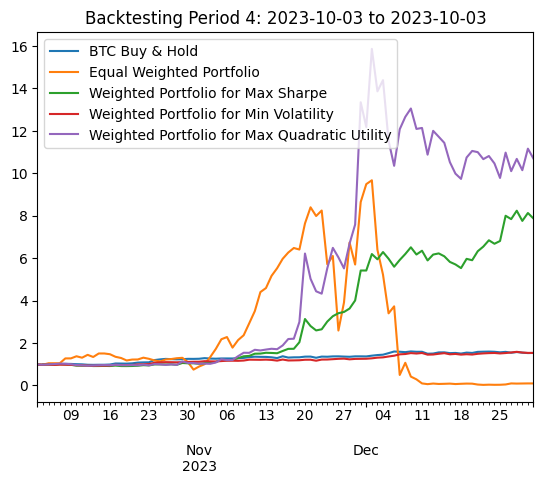

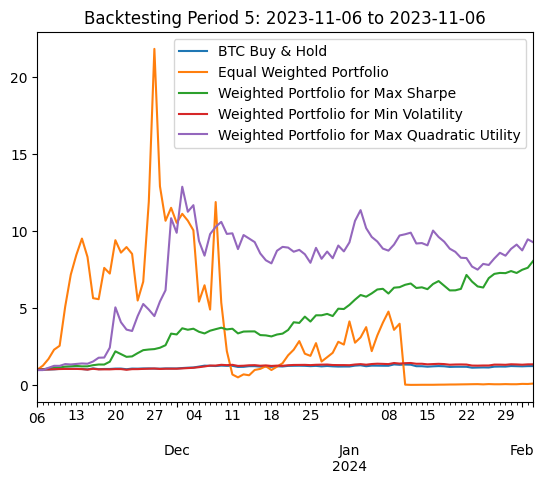

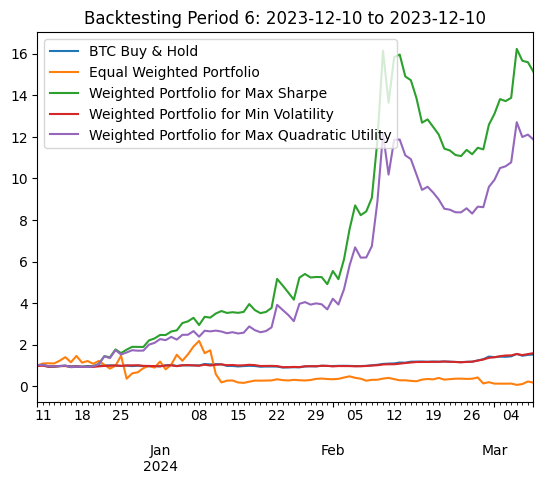

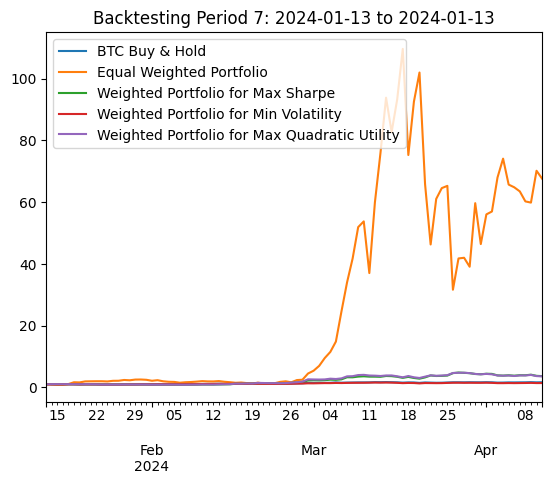

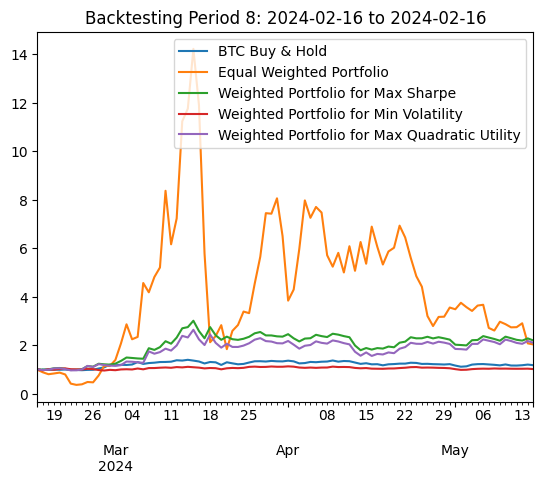

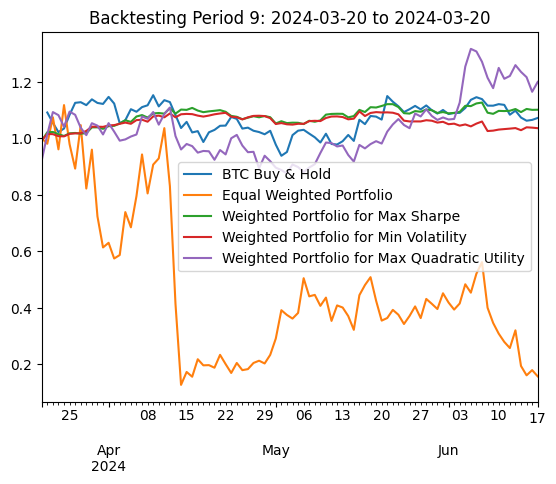

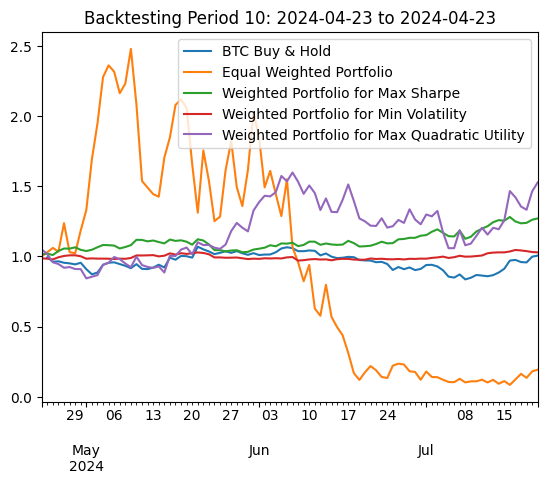

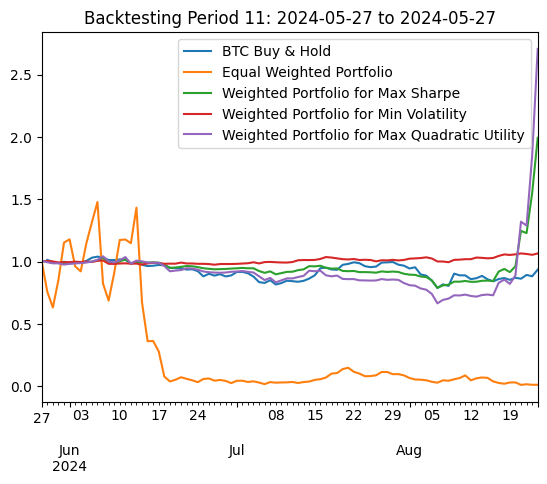

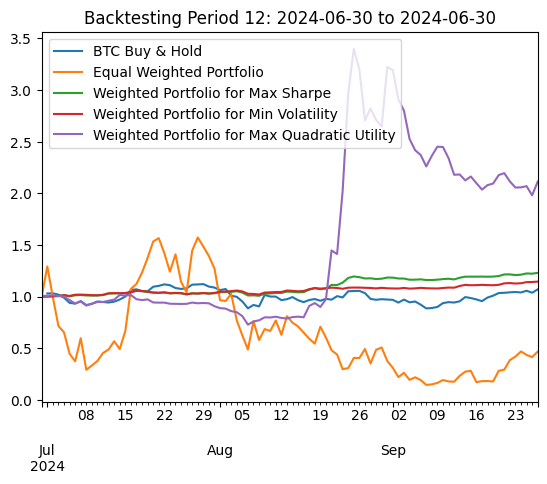

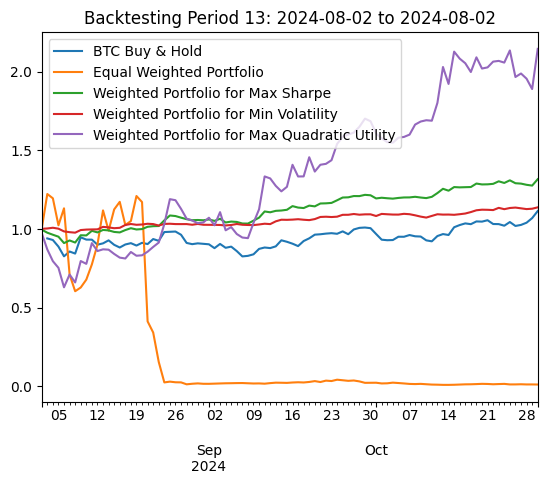

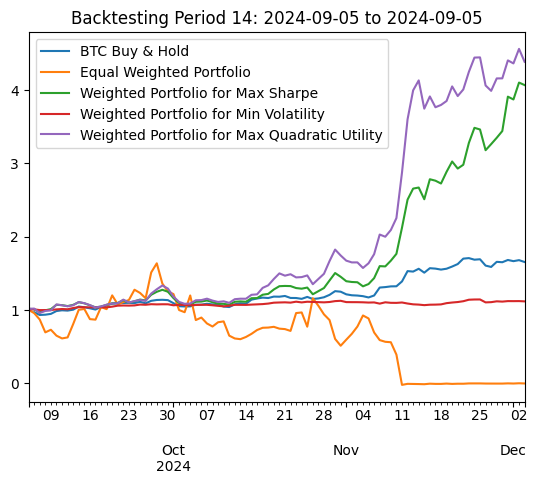

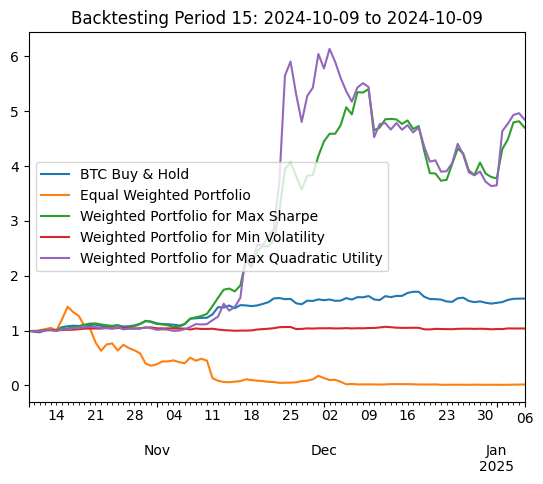

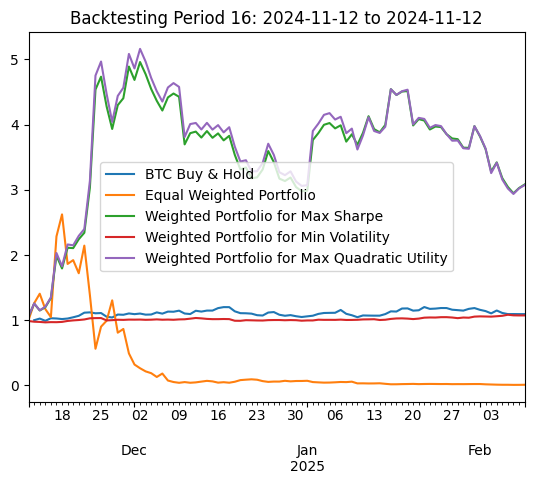

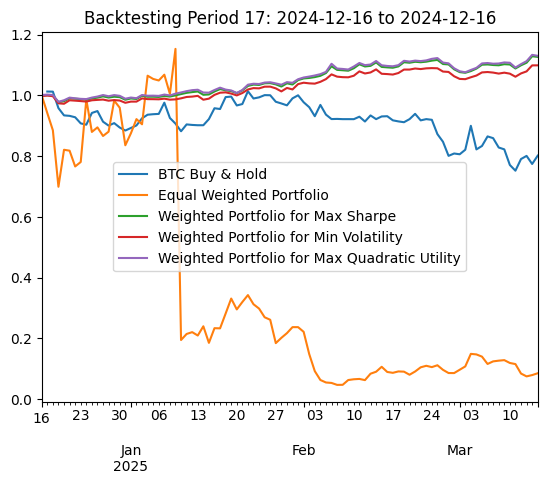

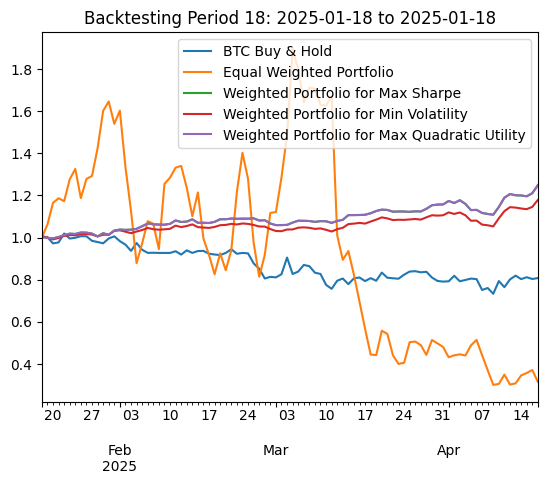

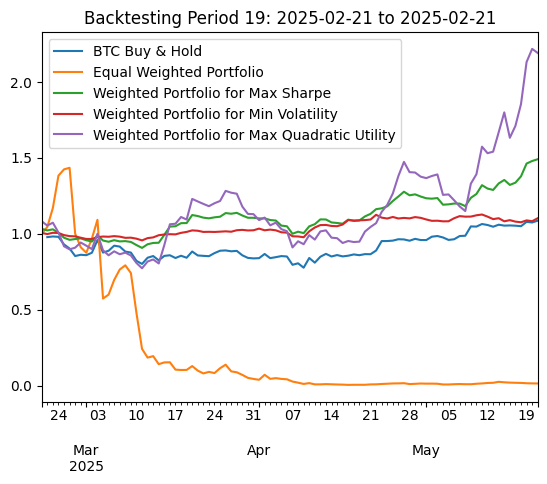

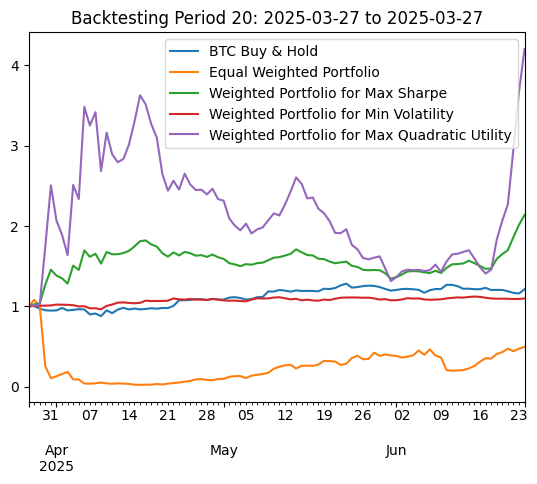

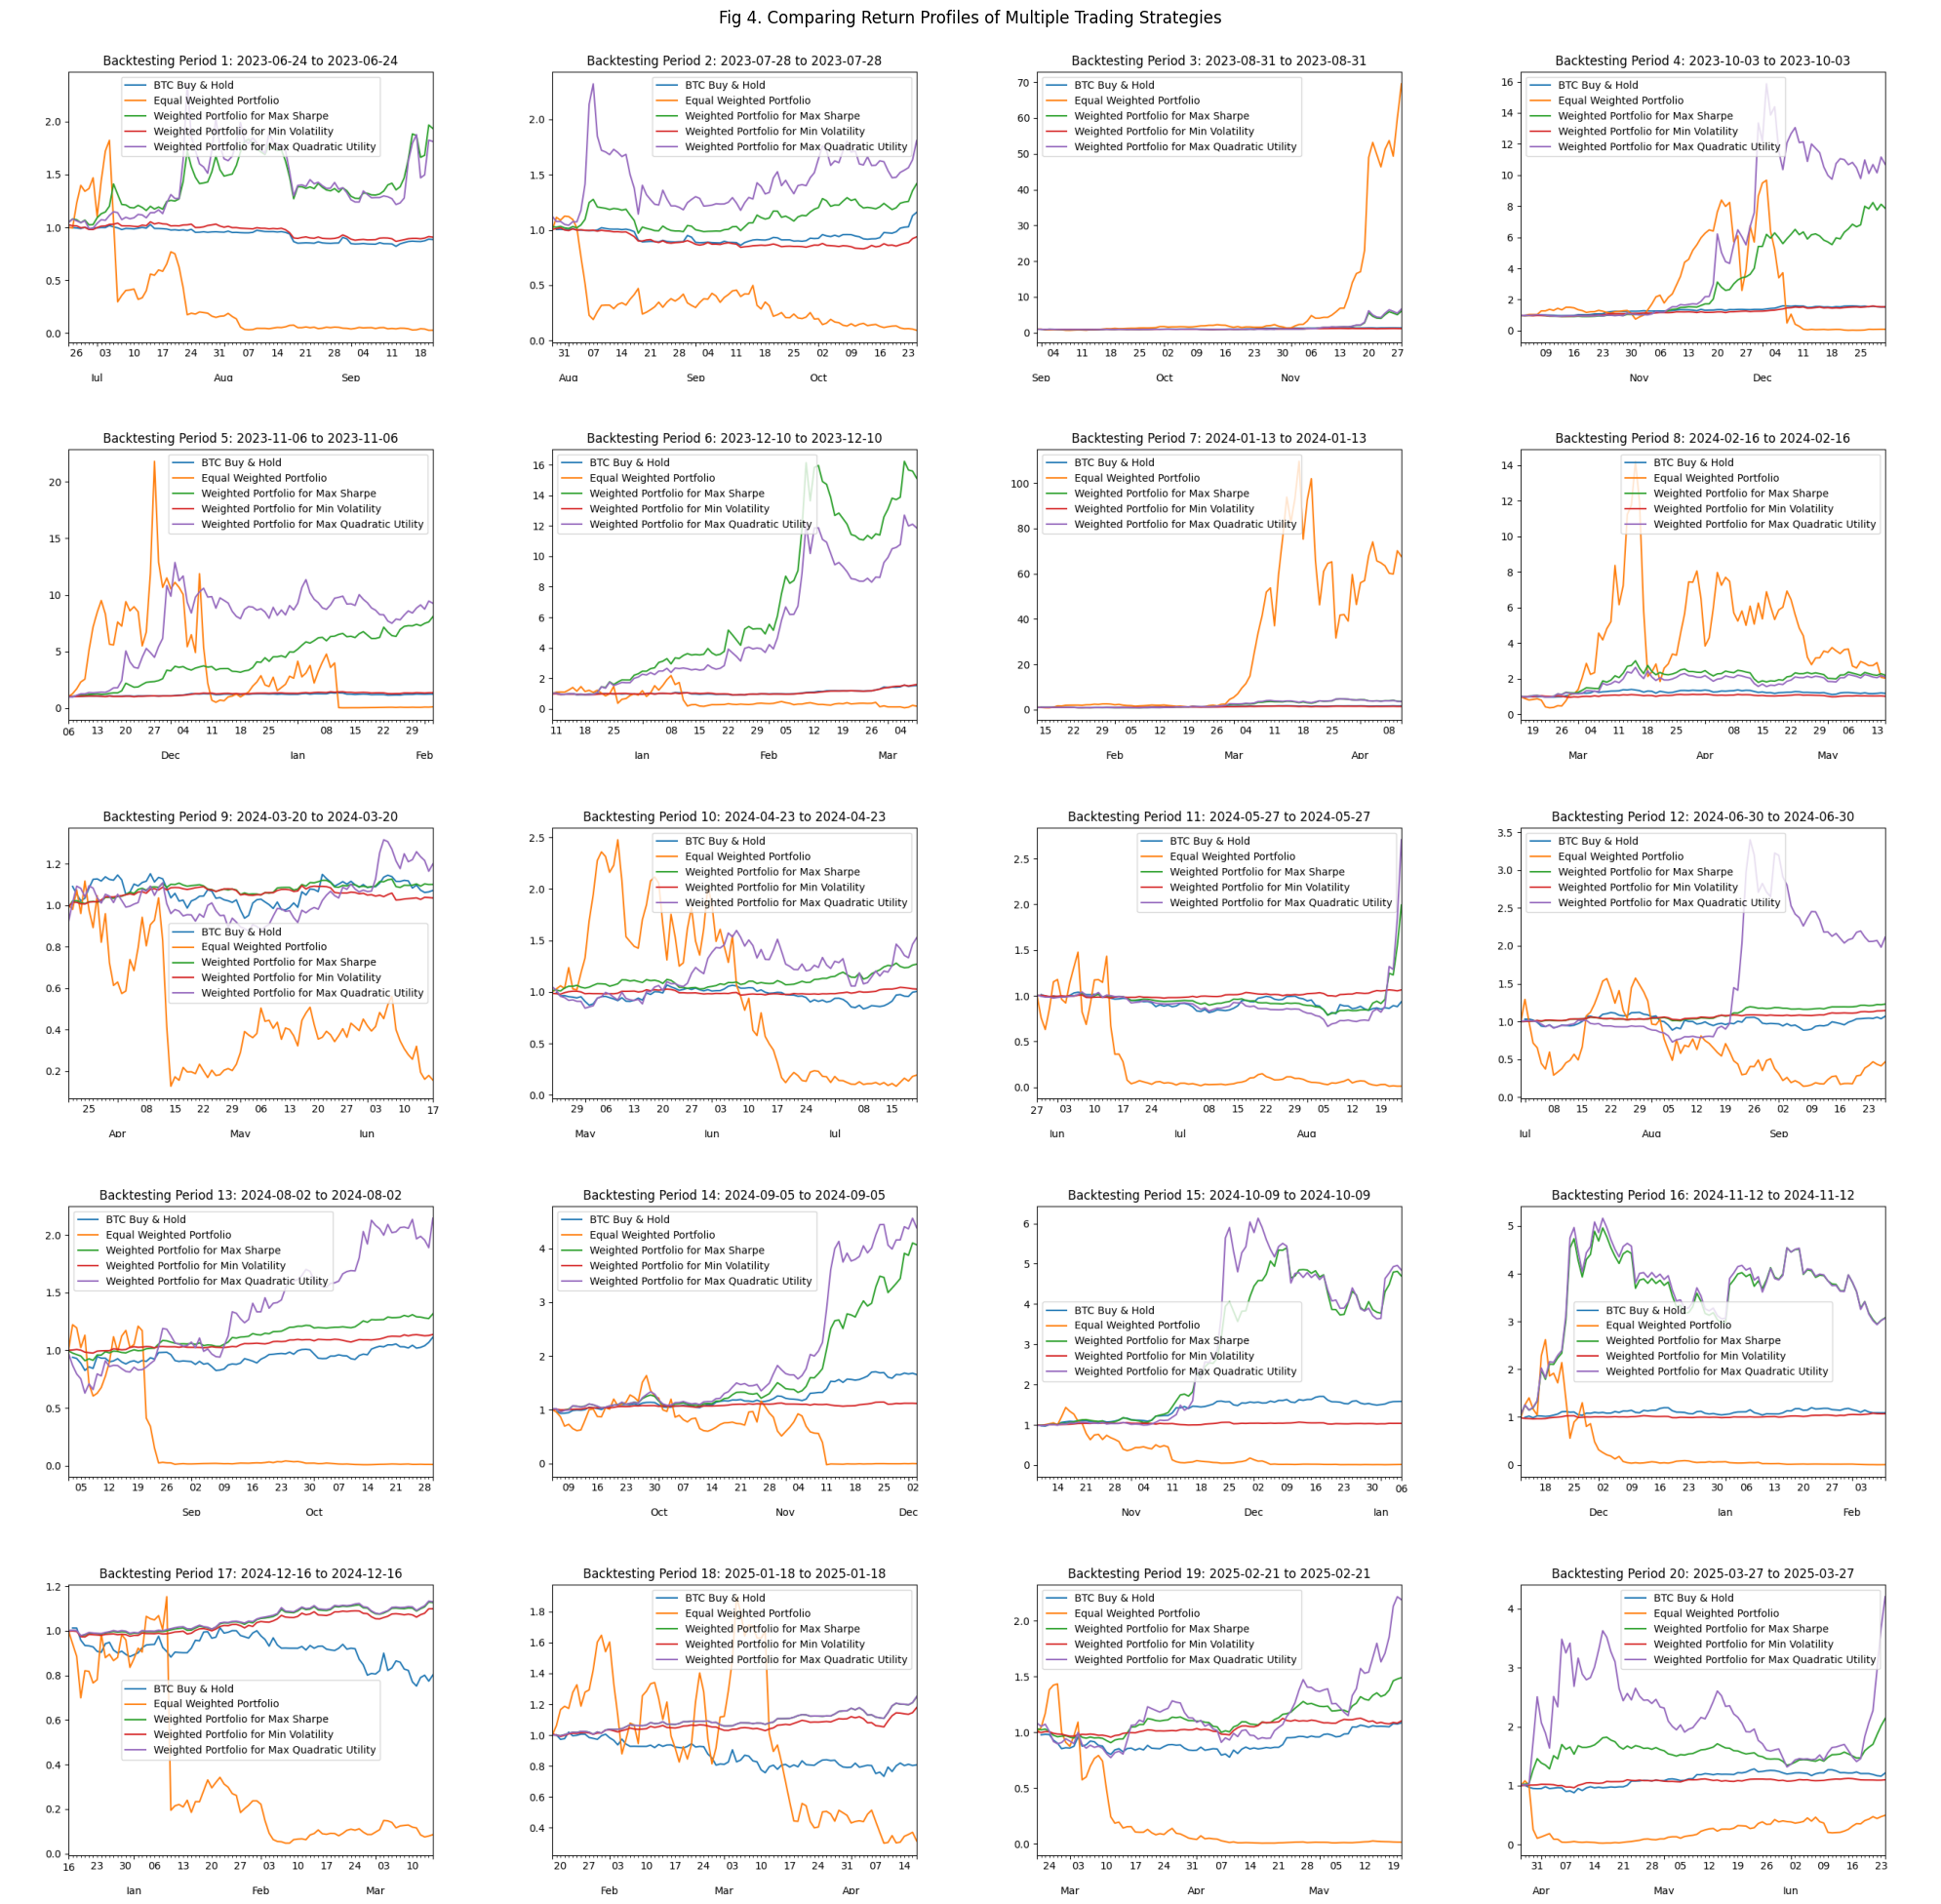

In [22]:
titles = [f"Backtesting Period {i[0]+1}: {str(i[1].min().date())} to {str(i[1].min().date())}" for i in enumerate(out_indexes)]

def axes_to_image(ax):
    fig = ax.figure
    canvas = FigureCanvas(fig)  # Attach new canvas
    canvas.draw()
    
    width, height = canvas.get_width_height()
    image = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8).reshape(height, width, 4)  # RGBA

    return image

# Convert each Axes to image
images = [axes_to_image(ax) for ax in [i[1].plot(title=titles[i[0]]) for i in enumerate(plots)]]

# Automatically determine layout
n = len(images)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

fig, axes = plt.subplots(cols, rows, figsize=(4 * cols, 5 * rows))
axes = axes.flatten()

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis("off")

# Hide extra axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Fig 4. Comparing Return Profiles of Multiple Trading Strategies")
plt.tight_layout()
plt.show()

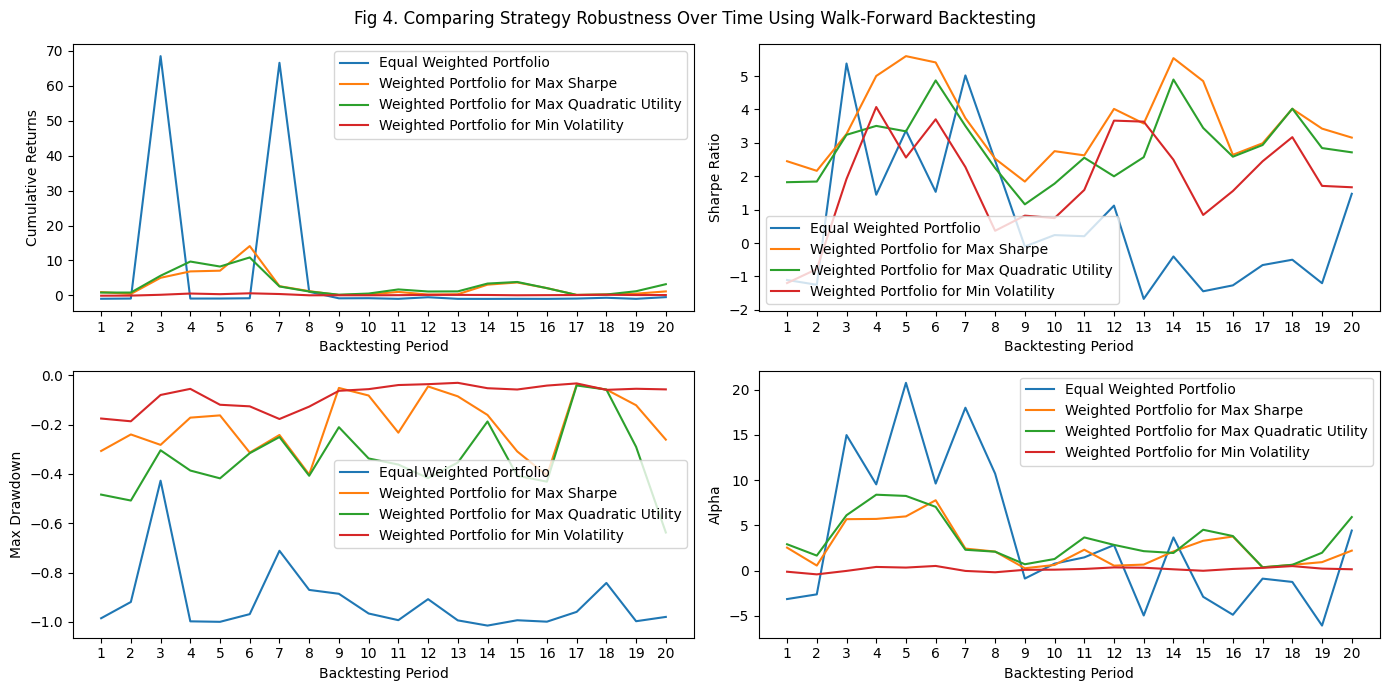

In [23]:
df = pd.concat(performance_stats, axis=0).reset_index()

# Metrics you want to plot
metrics = ["Cumulative Return", "Sharpe Ratio", "Max Drawdown", "Alpha"]
titles = ["Cumulative Returns", "Sharpe Ratio", "Max Drawdown", "Alpha"]
portfolios = [
    "Equal Weighted Portfolio",
    "Weighted Portfolio for Max Sharpe",
    "Weighted Portfolio for Max Quadratic Utility",
    "Weighted Portfolio for Min Volatility"
]

fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axes = axes.flatten()

for ax, metric, title in zip(axes, metrics, titles):
    for port in portfolios:
        (
            df[df["index"] == port][metric]
            .rename(port)
            .reset_index(drop=True)
            .set_axis(pd.Index(range(1, 21)))
            .plot(ax=ax)
        )
    
    ax.set_ylabel(title)
    ax.set_xlabel("Backtesting Period")
    ax.set_xticks(range(1, 21))
    ax.legend()

plt.suptitle("Fig 4. Comparing Strategy Robustness Over Time Using Walk-Forward Backtesting")
fig.tight_layout()
plt.show()

In [46]:
def plot_signals_and_pnl(pair, rolling_params, test_norm, test, threshold=1.0, capital_per_trade=100):
    import matplotlib.pyplot as plt
    import pandas as pd

    coin1, coin2 = pair

    # Z-score and normalized prices (for plotting)
    zscore_series = rolling_params[pair]["rolling_z_score"].loc[test_norm.index]
    coin1_norm = test_norm[coin1]
    coin2_norm = test_norm[coin2]

    # Actual price series (for PnL)
    coin1_actual = test[coin1]
    coin2_actual = test[coin2]

    # Define signals
    buy_signals = zscore_series[zscore_series < -threshold].index
    short_signals = zscore_series[zscore_series > threshold].index

    # Trade tracking
    trades = []
    current_position = None
    entry_date = None
    pnl_total = 0

    for i in range(1, len(zscore_series)):
        date = zscore_series.index[i]
        if current_position is None:
            if zscore_series[date] < -threshold:
                current_position = 'long'
                entry_date = date
            elif zscore_series[date] > threshold:
                current_position = 'short'
                entry_date = date
        elif current_position == 'long' and zscore_series[date] >= -threshold:
            pnl = (
                (coin1_actual[date] - coin1_actual[entry_date]) * 0.5 * capital_per_trade +
                (coin2_actual[entry_date] - coin2_actual[date]) * 0.5 * capital_per_trade
            )
            trades.append([entry_date.date(), date.date(), "long", round(pnl, 2)])
            pnl_total += pnl
            current_position = None
        elif current_position == 'short' and zscore_series[date] <= threshold:
            pnl = (
                (coin1_actual[entry_date] - coin1_actual[date]) * 0.5 * capital_per_trade +
                (coin2_actual[date] - coin2_actual[entry_date]) * 0.5 * capital_per_trade
            )
            trades.append([entry_date.date(), date.date(), "short", round(pnl, 2)])
            pnl_total += pnl
            current_position = None

    trades_df = pd.DataFrame(trades, columns=["Entry", "Exit", "Position", "PnL ($)"])
    num_trades = len(trades_df)
    initial_investment = capital_per_trade * num_trades
    final_value = initial_investment + pnl_total
    net_return_pct = (pnl_total / initial_investment) * 100 if initial_investment != 0 else 0

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(30, 5))

    # Plot Z-score
    zscore_series.rename("Z-Score").plot(ax=ax, color="black", linestyle="--", linewidth=1)
    test_norm[[coin1, coin2]].plot(ax=ax)

    ax.axhline(threshold, color="darkred", linestyle="--", linewidth=1, label=f"Upper Threshold (+{threshold})")
    ax.axhline(-threshold, color="navy", linestyle="--", linewidth=1, label=f"Lower Threshold (-{threshold})")

    ax.scatter(buy_signals, coin1_norm.loc[buy_signals], color='green', marker='^', s=80, label=f"Buy {coin1}", zorder=5)
    ax.scatter(buy_signals, coin2_norm.loc[buy_signals], color='red', marker='v', s=80, label=f"Short {coin2}", zorder=5)

    ax.scatter(short_signals, coin1_norm.loc[short_signals], color='darkred', marker='v', s=80, label=f"Short {coin1}", zorder=5)
    ax.scatter(short_signals, coin2_norm.loc[short_signals], color='darkgreen', marker='^', s=80, label=f"Buy {coin2}", zorder=5)

    ax.set_title(f"Z-Score & Trading Signals for {coin1} / {coin2}")
    ax.set_ylabel("Normalized Price / Z-Score")
    ax.set_xlabel("Date")
    # ax.legend(loc="upper left")
    ax.legend(loc="lower right", bbox_to_anchor=[0.95, 0.0, 0.25, 0.35])

    # --- Add Summary Table ---
    table_data = [
        ["Initial Investment", f"${initial_investment:.2f}"],
        ["Final Value", f"${final_value:.2f}"],
        ["Total PnL", f"${pnl_total:.2f}"],
        ["Net Return", f"{net_return_pct:.2f}%"],
        ["Total Trades", f"{num_trades}"]
    ]
    table = ax.table(cellText=table_data, colWidths=[0.15, 0.15],
                     colLabels=["Metric", "Value"],
                     cellLoc='center', loc='upper right', bbox=[1.02, 0.65, 0.25, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(12)

    plt.tight_layout()
    plt.show()

    # --- Return trade log as output if needed
    # return trades_df

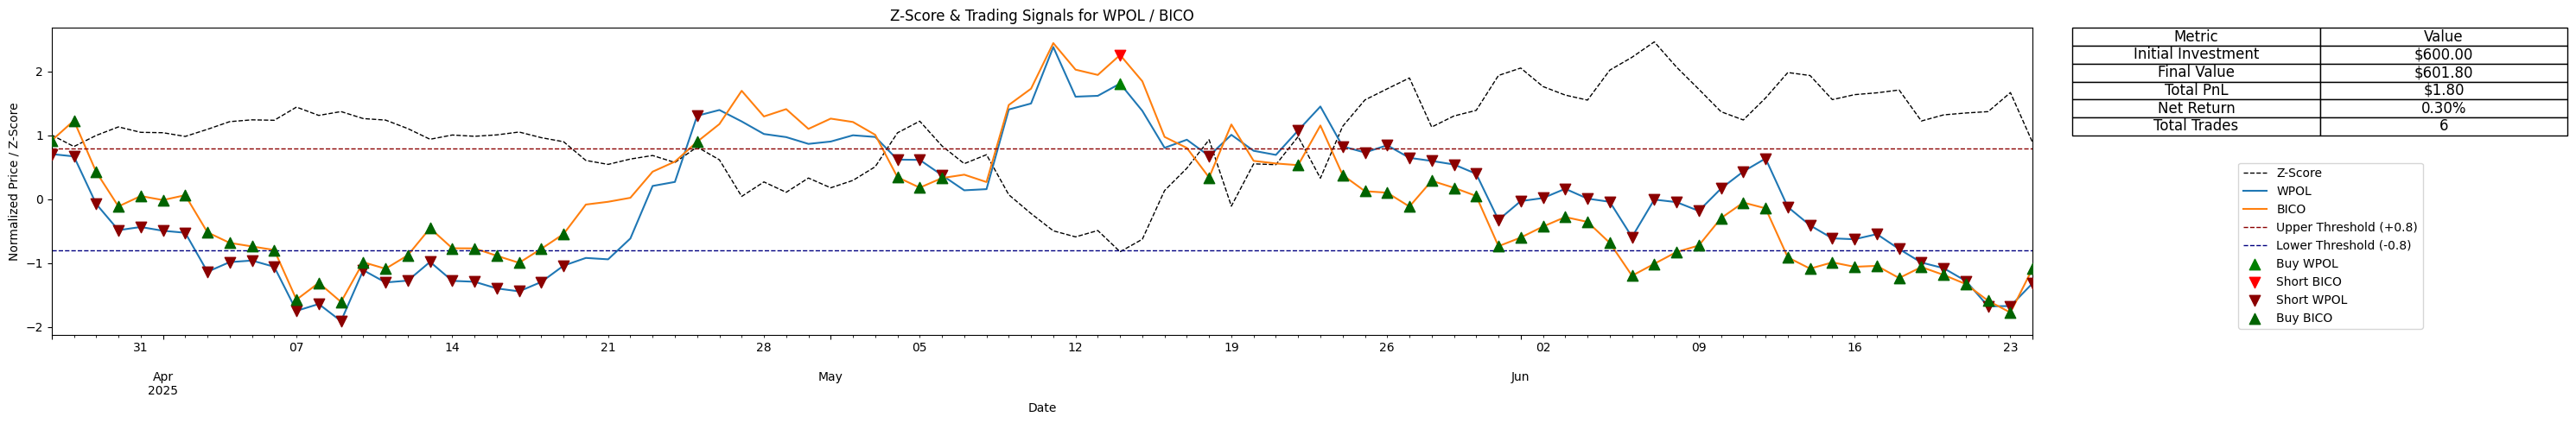

In [64]:
plot_signals_and_pnl(
    pair=tuple(final_pairs[5]),
    rolling_params=rolling_params,
    test_norm=test_norm,
    test=test,
    threshold=0.8,
    capital_per_trade=100
)

In [143]:
pd.DataFrame(rolling_params[tuple(final_pairs[0])])

,rolling_alpha,rolling_beta,rolling_spread,rolling_z_score
date,,,,
2022-06-25,NaN,NaN,NaN,NaN
2022-06-26,NaN,NaN,NaN,NaN
2022-06-27,NaN,NaN,NaN,NaN
2022-06-28,NaN,NaN,NaN,NaN
2022-06-29,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-06-20,-3.698213,2.612993,0.808635,-0.597439
2025-06-21,-3.736866,2.631348,1.094288,-0.402031
2025-06-22,-3.835689,2.678636,1.662977,-0.028672


In [65]:
from morse3 import Morse

In [67]:
morse = Morse(words="Hello World")

In [70]:
morse.stringToMorse()

'.... . .-.. .-.. ---   .-- --- .-. .-.. -.. '